In [1]:
import torch
import torchvision
import pathlib
import os
import matplotlib.pyplot as plt
import time
import copy

In [2]:
train_path = pathlib.Path('archive', 'training', 'training')
test_path = pathlib.Path('archive', 'validation', 'validation')
print(os.listdir(train_path))
print(os.listdir(test_path))

['n0', 'n1', 'n2', 'n3', 'n4', 'n5', 'n6', 'n7', 'n8', 'n9']
['n0', 'n1', 'n2', 'n3', 'n4', 'n5', 'n6', 'n7', 'n8', 'n9']


In [3]:
train_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224, 224)), 
    torchvision.transforms.ToTensor(),
])
test_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224, 224)), 
    torchvision.transforms.ToTensor(),
])
train_data = torchvision.datasets.ImageFolder(
    root=train_path,
    transform=train_transform)
test_data = torchvision.datasets.ImageFolder(
    root=test_path, 
    transform=test_transform
)
train_size = len(train_data)
train_size = len(train_data)

loaders = {
    'train': torch.utils.data.DataLoader(
        train_data,
        batch_size=32,
        shuffle=True, 
        num_workers=1,
    ),
    'test': torch.utils.data.DataLoader(
        test_data,
        batch_size=32,
        shuffle=True, 
        num_workers=1,
    ),
}

In [4]:
if torch.cuda.is_available(): 
 dev = "cuda:0" 
else: 
 dev = "cpu" 
device = torch.device(dev) 
device

device(type='cuda', index=0)

In [5]:
images, labels = next(iter(loaders['train']))

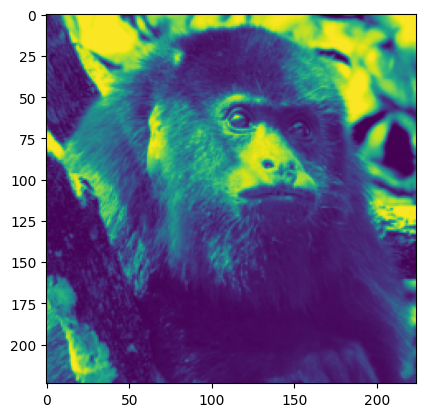

In [6]:
plt.imshow(images[0][2].numpy())

In [7]:
class simple_cnn(torch.nn.Module):
    def __init__(self):
        super(simple_cnn, self).__init__()
        # 224x224x3
        # self.bn0 = torch.nn.BatchNorm2d(),
        # 224x224x3
        self.conv1 = torch.nn.Sequential(
            torch.nn.Conv2d(3, 16, 3, 1, 1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2),
        )
        # 112x112x?
        self.conv2 = torch.nn.Sequential(
            torch.nn.Conv2d(16, 32, 3, 1, 1),
            torch.nn.ReLU(), 
            torch.nn.MaxPool2d(2),
        )
        # 56x56x?
        self.conv3 = torch.nn.Sequential(
            torch.nn.Conv2d(32, 64, 3, 1, 1), 
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2),
        )
        # 28x28x?
        self.conv4 = torch.nn.Sequential(
            torch.nn.Conv2d(64, 128, 3, 1, 1), 
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2),
        )
        self.fc5 = torch.nn.Linear(128*14*14, 10)
        # self.fc5 = torch.nn.Linear(32*56*56, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = x.view(x.size(0), -1)
        out = self.fc5(x)
        return out, x


In [11]:
learning_rate = 1e-3
print(learning_rate)
loss_func = torch.nn.CrossEntropyLoss()
monkey_cnn = simple_cnn()
optimizer = torch.optim.Adam(monkey_cnn.parameters(), lr=learning_rate)
num_epochs = 3
f_string = 'Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'


0.001


In [12]:
def train(num_epochs, cnn, loaders):
    cnn = cnn.to(device=dev)
    cnn.train()
    total_step=len(loaders['train'])
    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(loaders['train']):
            images = images.to(dev)
            labels = labels.to(dev)
            batch_x = torch.autograd.Variable(images)
            batch_y = torch.autograd.Variable(labels)
            output = cnn(batch_x)[0]
            loss = loss_func(output, batch_y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            if (i+1) % 10 == 0:
                print(f_string.format(epoch+1, num_epochs, i+1, total_step, loss.item()))
# train the ConvNet
train(num_epochs, monkey_cnn, loaders)
print("trained")

Epoch [1/3], Step [10/35], Loss: 2.2847
Epoch [1/3], Step [20/35], Loss: 2.2362
Epoch [1/3], Step [30/35], Loss: 2.2062
Epoch [2/3], Step [10/35], Loss: 1.9287
Epoch [2/3], Step [20/35], Loss: 1.5671
Epoch [2/3], Step [30/35], Loss: 1.9459
Epoch [3/3], Step [10/35], Loss: 1.6734
Epoch [3/3], Step [20/35], Loss: 1.6718
Epoch [3/3], Step [30/35], Loss: 1.6687
trained


### save/load simple monkey cnn

In [38]:
# torch.save(monkey_cnn, 'monkey_cnn.pth')
# monkey_cnn = torch.load('monkey_cnn.pth')

In [13]:
def test():
    monkey_cnn.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in loaders['test']:
            images = images.to(dev)
            labels = labels.to(dev)
            test_output, last_layer = monkey_cnn(images)
            pred_y = torch.max(test_output, 1)[1].data.squeeze()
            accuracy = (pred_y == labels).sum().item() / float(labels.size(0))
    # print("Accuracy: %.2f" % accuracy)
    return accuracy
print("Testing with simple cnn for monkey species classification")
for i in range(5):
    print(f'Test sample batch {i} -> Accuracy:', test())

Testing with simple cnn for monkey species classification
Test sample batch 0 -> Accuracy: 0.5
Test sample batch 1 -> Accuracy: 0.3125
Test sample batch 2 -> Accuracy: 0.375
Test sample batch 3 -> Accuracy: 0.375
Test sample batch 4 -> Accuracy: 0.25


## Frozen VGG16 + Monkey Classifier

In [14]:
monkey_FrozenVGG16 = torchvision.models.vgg16(pretrained=True)
# model = torchvision.models.resnet18(pretrained=True)
for param in monkey_FrozenVGG16.features.parameters():
    param.require_grad = False

c:\Users\kingo\AppData\Local\Programs\Python\Python38\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\kingo\AppData\Local\Programs\Python\Python38\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [15]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25, mode='train'):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        # Each epoch has a training and validation phase
        # for phase in ['train']:
        if mode == 'train':
            model.train()  # Set model to training mode
        else:
            model.eval()   # Set model to evaluate mode
        running_loss = 0.0
        running_corrects = 0
        # Iterate over data.
        for inputs, labels in loaders['train']:
            inputs = inputs.to(device)
            labels = labels.to(device)
            with torch.set_grad_enabled(mode == 'train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)
                if mode == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
        if mode == 'train':
            scheduler.step()
        epoch_loss = running_loss / train_size
        epoch_acc = running_corrects.double() / train_size
        print('{} Loss: {:.4f} Acc: {:.4f}'.format(
            mode, epoch_loss, epoch_acc))
        # deep copy the model
        if mode == 'test' and epoch_acc > best_acc:
            best_acc = epoch_acc
            best_model_wts = copy.deepcopy(model.state_dict())
        print()
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best test Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model


### Replacing last layer

In [19]:
# Replacing the last layer with a new layer to learn monkey species
infts = monkey_FrozenVGG16.classifier[-1].in_features
monkey_FrozenVGG16.classifier[-1] = torch.nn.Linear(infts, 10)
monkey_FrozenVGG16.to(dev)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(monkey_FrozenVGG16.parameters(), lr=0.001)
step_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)


In [23]:
print("Model Learning on train set")
monkey_FrozenVGG16= train_model(monkey_FrozenVGG16, criterion, optimizer, step_lr_scheduler, num_epochs=5, mode='train')

Model Learning on train set
Epoch 0/4
----------
train Loss: 1.2129 Acc: 0.7065

Epoch 1/4
----------
train Loss: 0.5107 Acc: 0.8578

Epoch 2/4
----------
train Loss: 0.3013 Acc: 0.9152

Epoch 3/4
----------
train Loss: 0.3042 Acc: 0.9088

Epoch 4/4
----------
train Loss: 0.2593 Acc: 0.9307

Training complete in 1m 37s
Best test Acc: 0.000000


In [25]:
print("Evaluation on test set")
monkey_FrozenVGG16= train_model(monkey_FrozenVGG16, criterion, optimizer, step_lr_scheduler, num_epochs=5, mode='test')

Evaluation on test set
Epoch 0/4
----------
test Loss: 1.6428 Acc: 0.6955

Epoch 1/4
----------
test Loss: 1.6428 Acc: 0.6955

Epoch 2/4
----------
test Loss: 1.6428 Acc: 0.6955

Epoch 3/4
----------
test Loss: 1.6428 Acc: 0.6955

Epoch 4/4
----------
test Loss: 1.6428 Acc: 0.6955

Training complete in 1m 35s
Best test Acc: 0.695533


### Unfreezing weights and allowing all layers to learn

In [33]:
for param in monkey_FrozenVGG16.features.parameters():
    param.require_grad = True

In [34]:
optimizer = torch.optim.SGD(monkey_FrozenVGG16.parameters(), lr=0.001)
step_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [35]:
print("Model Learning on train set after unfreezing weights")
monkey_FrozenVGG16= train_model(monkey_FrozenVGG16, criterion, optimizer, step_lr_scheduler, num_epochs=5, mode='train')

Model Learning on train set after unfreezing weights
Epoch 0/4
----------
train Loss: 1.2240 Acc: 0.6837

Epoch 1/4
----------
train Loss: 0.5018 Acc: 0.8715

Epoch 2/4
----------
train Loss: 0.2659 Acc: 0.9307

Epoch 3/4
----------
train Loss: 0.1852 Acc: 0.9417

Epoch 4/4
----------
train Loss: 0.1302 Acc: 0.9626

Training complete in 1m 22s
Best test Acc: 0.000000


In [36]:
print("Evaluation on test set after unfreezing weights")
monkey_FrozenVGG16= train_model(monkey_FrozenVGG16, criterion, optimizer, step_lr_scheduler, num_epochs=5, mode='test')

Evaluation on test set after unfreezing weights
Epoch 0/4
----------
test Loss: 1.6393 Acc: 0.6955

Epoch 1/4
----------
test Loss: 1.6393 Acc: 0.6955

Epoch 2/4
----------
test Loss: 1.6393 Acc: 0.6955

Epoch 3/4
----------
test Loss: 1.6393 Acc: 0.6955

Epoch 4/4
----------
test Loss: 1.6393 Acc: 0.6955

Training complete in 1m 43s
Best test Acc: 0.695533


In [13]:
# import gc
# gc.collect()
# torch.cuda.empty_cache()